In [1]:
import torch
import torch_geometric as tg
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from torch.utils.data import DataLoader
from torch_geometric_temporal import temporal_signal_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric_temporal.dataset import METRLADatasetLoader
import utils
import torch.nn as nn
import torch.nn.functional as F
from typing import Union, Callable, Optional
import torch.optim as optim
import time
from tqdm import tqdm
from torch_geometric_temporal.nn.attention import GMAN


/home/joshi.at/.conda/envs/dl_project3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loader = METRLADatasetLoader()
dataset = loader.get_dataset()

Data was normalized via Z-Score method with mean = [53.59967    0.4982691] and std = [20.209862    0.28815305]


In [3]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [4]:
X_train = torch.Tensor(np.array(train_dataset.features))

In [5]:
X_train.shape

torch.Size([27399, 207, 2, 12])

In [6]:
X_train = X_train.permute(0, 3, 1, 2)

In [7]:
X_train.shape

torch.Size([27399, 12, 207, 2])

In [8]:
y_train = torch.Tensor(np.array(train_dataset.targets))

In [9]:
y_train = y_train.permute(0,2,1)

In [10]:
X_test = torch.Tensor(np.array(test_dataset.features))
X_test = X_test.permute(0, 3, 1, 2)
y_test = torch.Tensor(np.array(test_dataset.targets))
y_test = y_test.permute(0,2,1)

In [11]:
def get_spatial_embedding(nodes, D, device):
    seq_len = nodes
    input_dim = D
    pe = torch.zeros(seq_len,1,input_dim).to(device)
    den  = 1/seq_len**((1/input_dim)*torch.arange(0,input_dim,2))
    num = torch.arange(seq_len).reshape(seq_len,1)
    pe[:,0,0::2] = torch.sin(num*den)
    pe[:,0,1::2] = torch.cos(num*den)
    pe=pe.squeeze()
    return pe

In [12]:
L=3
K=4
d=4
num_his=12
bn_decay = 0.99
steps_for_day=288
use_bias = True
mask = False
gman = GMAN(L,K,d,num_his,bn_decay,steps_for_day,use_bias,mask)

In [13]:
nodes=207
D=d*K
device = torch.device("cuda")
se = get_spatial_embedding(nodes,D,device)

In [14]:
se.shape

torch.Size([207, 16])

In [15]:
def get_temporal_embedding(x,y, pred_steps,bs):
    return torch.rand(bs,2*num_his,nodes)

In [16]:
X_train[:32,:,:,0].shape

torch.Size([32, 12, 207])

In [17]:
y_train.shape

torch.Size([27399, 12, 207])

In [21]:
gman = gman.to(device)
LEARNING_RATE = 1e-3
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(gman.parameters(), lr=LEARNING_RATE)
batch_size=32
te = get_temporal_embedding(1,2,3,batch_size)
total_nu_batches = X_train.shape[0]//batch_size
train_loss=[]
NUM_EPOCHS=10
start = time.time()
for j in range(NUM_EPOCHS):
    print("epoch {} time {}".format(j,time.time()-start))
    for i in range(total_nu_batches):
        data = X_train[i*batch_size:i*batch_size+batch_size,:,:,0].to(device)
        target = y_train[i*batch_size:i*batch_size+batch_size,:,:].to(device)
        output = gman(data,se,te)
        loss = loss_fn(output,target)
        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    torch.save(gman.state_dict(),'logs/basic_run_'+str(j))
    test_loss = evaluate()
    eval_result(test_loss)

epoch 0 time 0.00030803680419921875
norm loss:0.30887648463249207
unnormalized loss: 59.84202112946779
epoch 1 time 250.72313356399536
norm loss:0.3851225674152374
unnormalized loss: 61.38294394054765
epoch 2 time 491.59760451316833
norm loss:0.3841313123703003
unnormalized loss: 61.36291081288267
epoch 3 time 733.132381439209
norm loss:0.3841133713722229
unnormalized loss: 61.36254822778738
epoch 4 time 974.9256074428558


KeyboardInterrupt: 

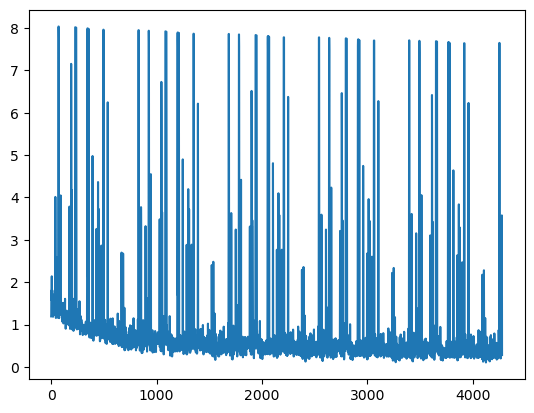

In [22]:
plt.plot(train_loss)

In [19]:
def evaluate():
    test_loss = []
    with torch.no_grad():
        gman.eval()
        total_test_batches = X_test.shape[0]//batch_size
        for i in range(total_test_batches):
            data = X_test[i*batch_size:i*batch_size+batch_size,:,:,0].to(device)
            target = y_test[i*batch_size:i*batch_size+batch_size,:,:].to(device)
            output = gman(data,se,te)
            loss = loss_fn(output,target)
            test_loss.append(loss.item())
            return test_loss

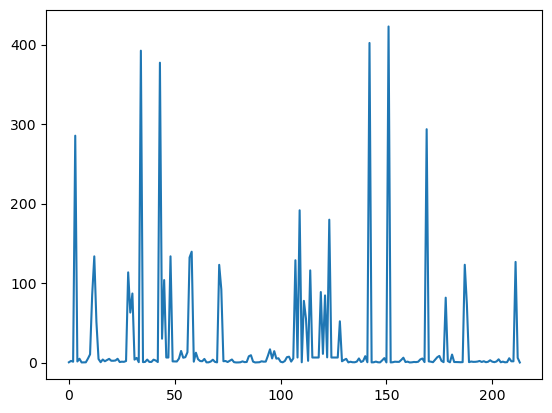

In [23]:
plt.plot(test_loss)

In [20]:
def eval_result(test_loss):
    mean = 53.59967
    std = 20.209862
    norm_loss = np.mean(test_loss)
    print("norm loss:{}".format(norm_loss))
    unnorm_loss = norm_loss*std+mean
    print("unnormalized loss: {}".format(unnorm_loss))